In [9]:
import numpy as np
import numpy.linalg as npla
import random
import matplotlib.pyplot as plt

In [10]:
# Classical Gram-Schmidt QR
def CGS(A):
    assert(len(np.shape(A)) == 2)
    m, n = np.shape(A)
    Q = np.copy(A)
    R = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            Q[:, i] -= np.dot(Q[:, j], A[:, i]) * Q[:, j]
        Q[:, i] /= npla.norm(Q[:, i], 2)
    for i in range(n):
        for j in range(i, n):
            R[i, j] = np.dot(A[:, j], Q[:, i])
    return Q, R

# Modified Gram-Schmidt QR
def MGS(A):
    assert(len(np.shape(A)) == 2)
    m, n = np.shape(A)
    Q = np.copy(A)
    R = np.zeros((n, n))
    for k in range(n):
        R[k, k] = npla.norm(Q[:, k])
        Q[:, k] /= R[k, k]
        R[k, k+1:n] = Q[:, k].T @ Q[:, k+1:n]
        Q[:, k+1:n] -= Q[:, k].reshape(-1, 1) @ R[k, k+1:n].reshape(1, -1)
    return Q, R

In [11]:
# function to generate a matrix with a condition number
def gen_matrix(shape, kappa):
    A = np.random.randn(*shape)
    u, s, v = npla.svd(A, full_matrices=True)
    s = s[0] * (1 - ((kappa-1) / kappa)*(s[0]-s) / (s[0] - s[-1]))   
    s = np.diag(s)
    return u @ s @ v

In [12]:
def loss_of_ortho(n):
    kappa = 1
    cond, C, M = [], [], []
    while (kappa < 1e10):
        A = gen_matrix((n, n), kappa)
        Q_C, _ = CGS(A)
        Q_M, _ = MGS(A)
        C.append(npla.norm(np.eye(n) - Q_C @ Q_C.T, 2))
        M.append(npla.norm(np.eye(n) - Q_M @ Q_M.T, 2))
        cond.append(npla.cond(A))
        kappa *= random.uniform(1, 1.5)

    plt.xscale('log')
    plt.yscale('log')
    plt.title('Loss of orthogonality in CGS and MGS: ' + str(n) + 'x' + str(n) + ' matrix')
    plt.xlabel(r'Condition number $\kappa(A)$')
    plt.ylabel(r'$\| I - Q^TQ \|_2$')
    plt.plot(cond, C, label = "Classical Gram Schmidt")
    plt.plot(cond, M, label = "Modified Gram Schmidt")
    plt.legend()

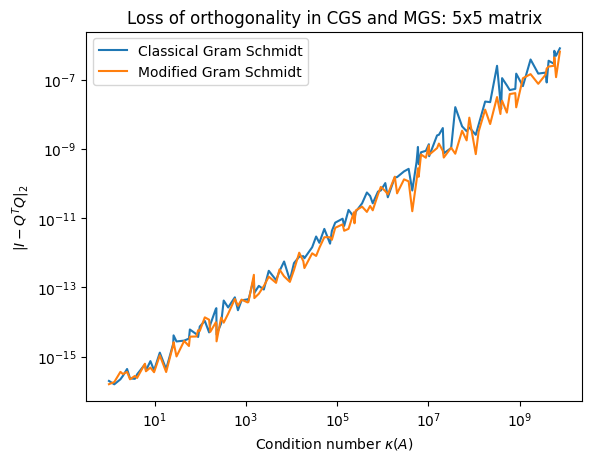

In [5]:
loss_of_ortho(5)

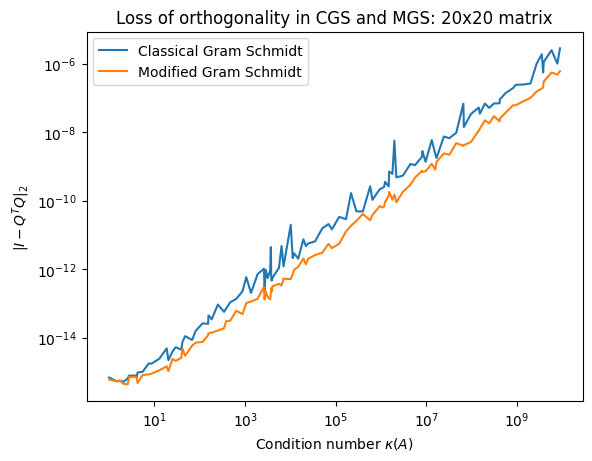

In [6]:
loss_of_ortho(20)

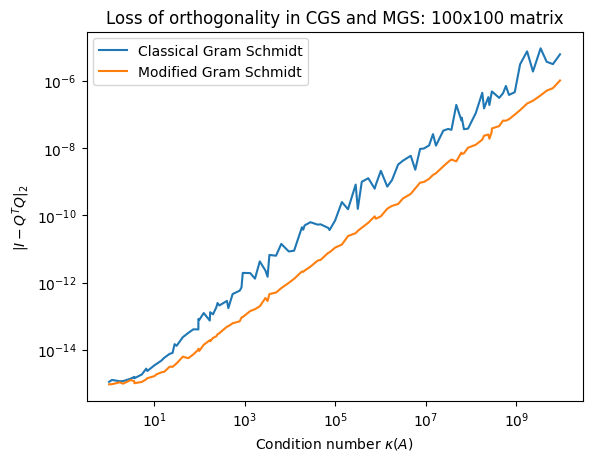

In [7]:
loss_of_ortho(100)

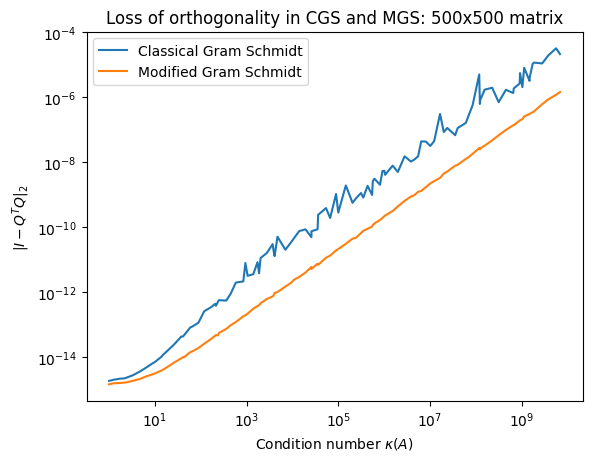

In [8]:
loss_of_ortho(500)

In [13]:
# This block is for reorthogonalization methods, which are designed so that Q is orthogonal to the round-off error

# Classical Method, reorthogonalized
def CGS2(A):
    assert(len(np.shape(A)) == 2)
    m, n = np.shape(A)
    Q = np.copy(A)
    R = np.zeros((n, n))
    for k in range(n):
        for i in range(2):
            V = Q[:, :k].T @ Q[:, k]
            Q[:, k] -= Q[:, :k] @ V
            R[:k, k] += V
        R[k, k] = npla.norm(Q[:, k])
        Q[:, k] /= R[k, k]
    return Q, R

# Modified Method, reorthogonalized
def MGS2(A):
    assert(len(np.shape(A)) == 2)
    m, n = np.shape(A)
    Q = np.copy(A)
    R = np.zeros((n, n))
    for k in range(n):
        for i in list(range(k)) + list(range(k-1, -1, -1)):
            V = Q[:, i].T @ Q[:, k]
            Q[:, k] -= V * Q[:, i]
            R[i, k] += V
        R[k, k] = npla.norm(Q[:, k])
        Q[:, k] /= R[k, k]
    return Q, R

In [14]:
def loss_of_ortho_expanded(n):
    kappa = 1
    cond, C, M, C2, M2 = [], [], [], [], []
    while (kappa < 1e10):
        A = gen_matrix((n, n), kappa)
        Q_C, _ = CGS(A)
        Q_M, _ = MGS(A)
        Q_C2, _ = CGS2(A)
        Q_M2, _ = MGS2(A)
        C.append(npla.norm(np.eye(n) - Q_C @ Q_C.T, 2))
        M.append(npla.norm(np.eye(n) - Q_M @ Q_M.T, 2))
        C2.append(npla.norm(np.eye(n) - Q_C2 @ Q_C2.T, 2))
        M2.append(npla.norm(np.eye(n) - Q_M2 @ Q_M2.T, 2))
        cond.append(npla.cond(A))
        kappa *= random.uniform(1, 1.5)

    plt.xscale('log')
    plt.yscale('log')
    plt.title('Loss of orthogonality: ' + str(n) + 'x' + str(n) + ' matrix')
    plt.xlabel(r'Condition number $\kappa(A)$')
    plt.ylabel(r'$\| I - Q^TQ \|_2$')
    plt.plot(cond, C, label = "Classical")
    plt.plot(cond, M, label = "Modified")
    plt.plot(cond, C2, label = "Reorthogonalized Classical")
    plt.plot(cond, M2, label = "Reorthogonalized Modified")
    plt.legend()

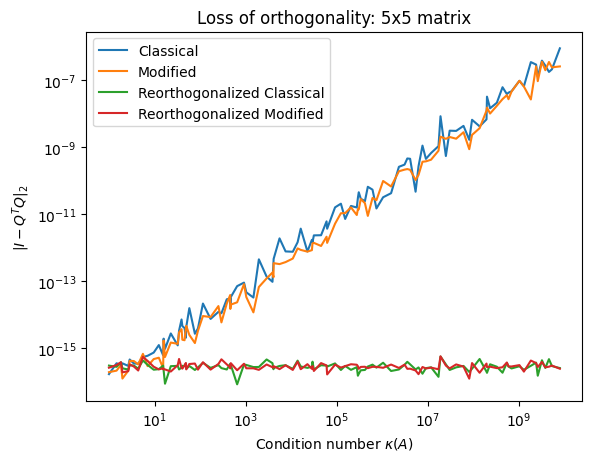

In [15]:
loss_of_ortho_expanded(5)

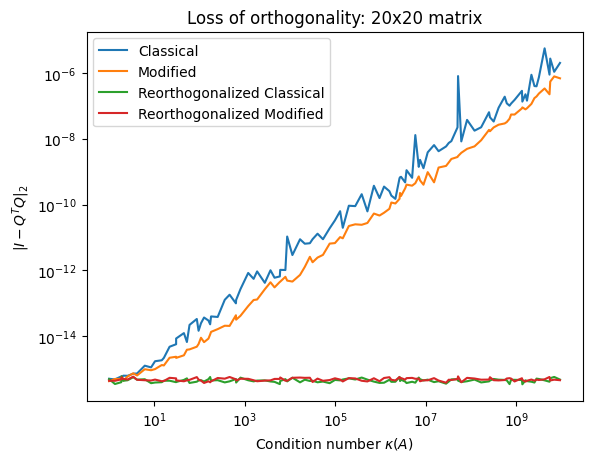

In [16]:
loss_of_ortho_expanded(20)

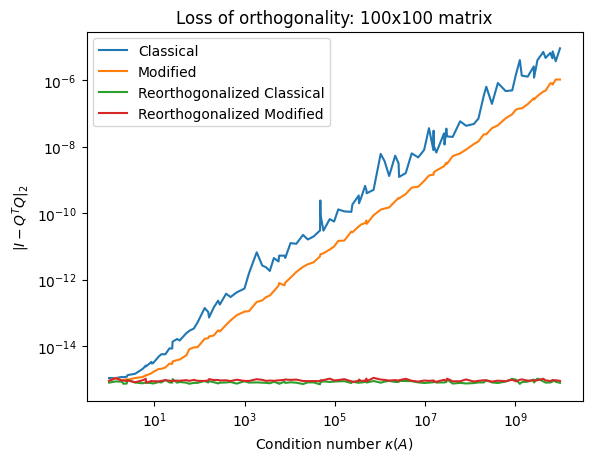

In [17]:
loss_of_ortho_expanded(100)

In [18]:
def loss_of_decomp_expanded(n):
    kappa = 1
    cond, C, M, C2, M2 = [], [], [], [], []
    while (kappa < 1e10):
        A = gen_matrix((n, n), kappa)
        Q_C, R_C = CGS(A)
        Q_M, R_M = MGS(A)
        Q_C2, R_C2 = CGS2(A)
        Q_M2, R_M2 = MGS2(A)
        C.append(npla.norm(A - Q_C @ R_C, 2))
        M.append(npla.norm(A - Q_M @ R_M, 2))
        C2.append(npla.norm(A - Q_C2 @ R_C2, 2))
        M2.append(npla.norm(A - Q_M2 @ R_M2, 2))
        cond.append(npla.cond(A, 2))
        kappa *= random.uniform(1, 1.5)

    plt.xscale('log')
    plt.yscale('log')
    plt.title('Loss of decomposition: ' + str(n) + 'x' + str(n) + ' matrix')
    plt.xlabel(r'Condition number $\kappa(A)$')
    plt.ylabel(r'$\| A - Q R \|_2$')
    plt.plot(cond, C, label = "Classical")
    plt.plot(cond, M, label = "Modified")
    plt.plot(cond, C2, label = "Reorthogonalized Classical")
    plt.plot(cond, M2, label = "Reorthogonalized Modified")
    plt.legend()

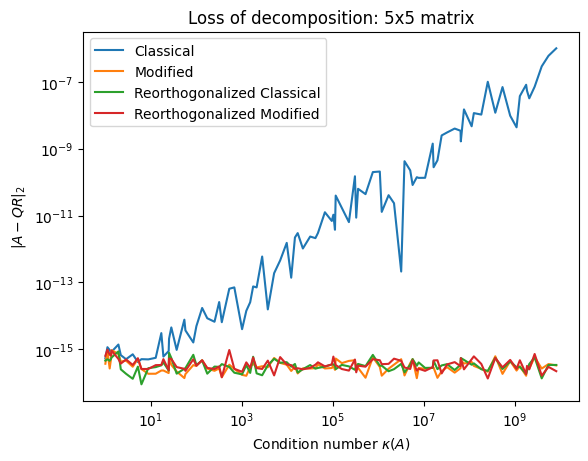

In [19]:
loss_of_decomp_expanded(5)

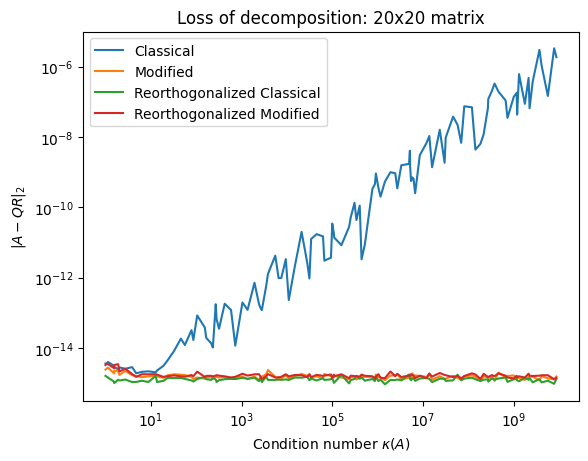

In [20]:
loss_of_decomp_expanded(20)

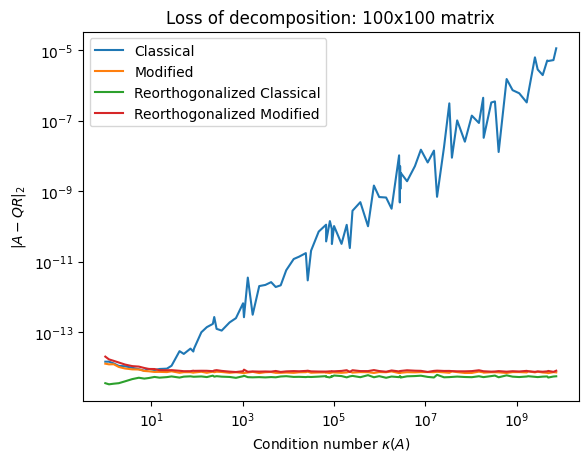

In [21]:
loss_of_decomp_expanded(100)

In [22]:
# function to generate a singular matrix with a given norm
def gen_singular_matrix(shape, norm):
    A = np.random.randn(*shape)
    u, s, v = npla.svd(A, full_matrices=True)
    s *= (norm / s[0])   
    s[-1] = 0
    s = np.diag(s)
    return u @ s @ v[:len(s)]

In [23]:
def loss_of_decomp_singular(n):
    norm = 1
    norm_arr, C, M, C2, M2 = [], [], [], [], []
    while (norm < 1e10):
        A = gen_singular_matrix((n, n), norm)
        Q_C, R_C = CGS(A)
        Q_M, R_M = MGS(A)
        Q_C2, R_C2 = CGS2(A)
        Q_M2, R_M2 = MGS2(A)
        C.append(npla.norm(A - Q_C @ R_C, 2))
        M.append(npla.norm(A - Q_M @ R_M, 2))
        C2.append(npla.norm(A - Q_C2 @ R_C2, 2))
        M2.append(npla.norm(A - Q_M2 @ R_M2, 2))
        norm_arr.append(npla.norm(A, 2))
        norm *= random.uniform(1, 1.5)

    plt.xscale('log')
    plt.yscale('log')
    plt.title('Loss of decomposition: ' + str(n) + 'x' + str(n) + ' singular matrix')
    plt.xlabel(r'2-norm $\| A \|_2$')
    plt.ylabel(r'$\| A - Q R \|_2$')
    plt.plot(norm_arr, C, label = "Classical")
    plt.plot(norm_arr, M, label = "Modified")
    plt.plot(norm_arr, C2, label = "Reorthogonalized Classical")
    plt.plot(norm_arr, M2, label = "Reorthogonalized Modified")
    plt.legend()

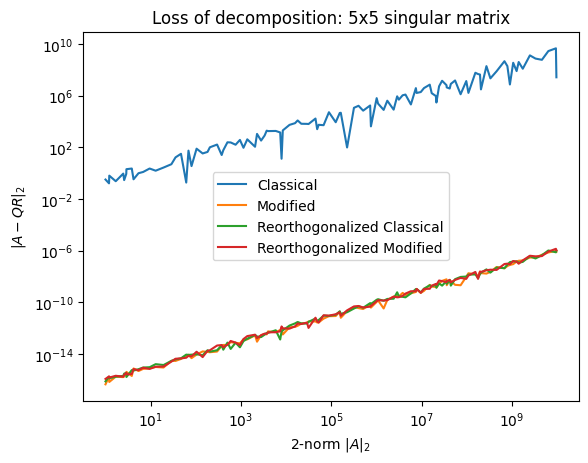

In [24]:
loss_of_decomp_singular(5)

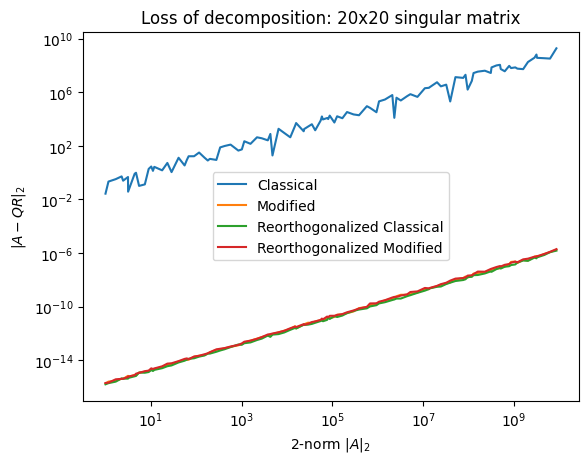

In [25]:
loss_of_decomp_singular(20)

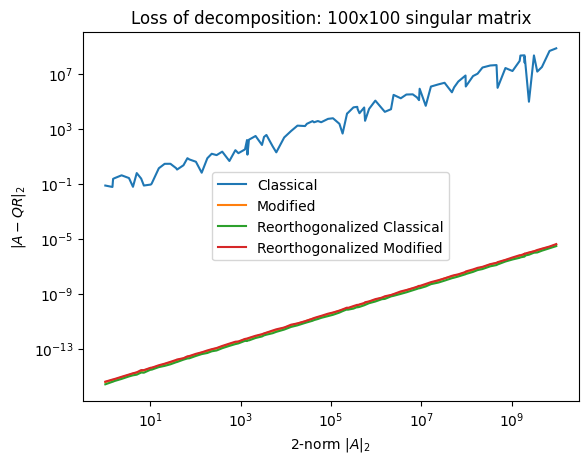

In [26]:
loss_of_decomp_singular(100)